In [87]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load ../src/weather_data_clean.py
import pandas as pd

def clean_weather_data(filename):
    """Take ASOS weather data file for Stampede pass and clean it ready for input to model.
    Input: txt file
    Output: pandas dataframe
    """
    data = pd.read_csv(filename)

    # Rename two of the columns
    data.rename(columns={'valid':'date', 'tmpf':'temp'}, inplace=True)

    # Remove the few rows that have a null value for temp
    data = data[~data.temp.eq('M')]

    # Remove spaces from column names
    data.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

    # Only use the standard hourly weather reading at 56 mins past each hour
    mask = data['date'].apply(lambda x: x[-2:] == '56')
    data = data[mask]

    # Create a date series to be used in the clean dataframe
    date = pd.to_datetime(data['date'])

    # Create a temp series to be used in the clean dataframe
    temp = data['temp'].apply(float)

    # Cast the null value M to zero to enable create of the raw precipitation series cast to floats
    data.p01i[data.p01i == 'M'] = 0
    raw_precipitation = data['p01i'].apply(float)

    # Create a precipitation series to be used in the clean dataframe
    precipitation = raw_precipitation.apply(lambda x: True if (x > 0) else False)

    # Convert sky coverage data to clear or cloudy and create an overcast series to be used in the clean dataframe
    sky_elements = ['skyc1', 'skyc2', 'skyc3']
    data.skyc1 = data.skyc1.astype(str)
    data.skyc2 = data.skyc2.astype(str)
    data.skyc3 = data.skyc3.astype(str)
    sky_agg = data[sky_elements].values.tolist()
    sky_reduce = [['overcast' if (('BKN' in element) or ('OVC' in element) or ('VV' in element)) else 'clear'
                    for element in row] for row in sky_agg]
    overcast = pd.Series([True if 'overcast' in row else False for row in sky_reduce])
    overcast.index = date.index

    # Cast the null value 'M' to 10.00 to enable the creation of a poor visibility series
    data.vsby[data.vsby == 'M'] = 10.00
    raw_visibility = data['vsby'].apply(float)
    poor_visibility = pd.Series([True if value < 0.50 else False for value in raw_visibility])
    poor_visibility.index = date.index

    # Cast the null value 'M' to 0 to enable the creation of a windy series
    data.sknt[data.sknt == 'M'] = 0.00
    data.gust[data.gust == 'M'] = 0.00
    wind_speed = data['sknt'].apply(float)
    gust_speed = data['gust'].apply(float)
    wind_df = pd.concat([wind_speed, gust_speed], axis=1)
    # Finally apply the function f to enable the creation of the windy column
    windy = wind_df.apply(f, axis=1)

    """Create the cleaned dataframe by concatenating the date, temp, precipitation, overcast, poor_visibility
    and windy series"""
    df = pd.concat([date, temp, precipitation, overcast, poor_visibility, windy], axis=1)
    df.columns = ['date', 'temp', 'precipitation', 'overcast', 'poor_visibility', 'windy']
    cleaned_df = df[(df['date'] > '2006-12-31') & (df['date'] < '2018-04-03')]
    return cleaned_df

def f(row):
    """Function to be able to create the windy series with windy being true if wind speed is above 10 knots
    or gust speed is above 20 knots"""
    if row['sknt'] >= 10.00:
        val = True
    elif row['gust'] >= 20.00:
        val = True
    else:
        val = False
    return val




In [3]:
weather_df = clean_weather_data('ASOS_stampede_pass/SMP-2.txt')

/Users/leanne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
# %load ../src/pass_data_clean.py
import pandas as pd

def clean_pass_data(filename):
    """Take Snoqualmie pass closure data file and clean it ready for input to model.
    Input: xlsx file
    Output: Pandas dataframe
    """
    data = pd.read_excel(filename, header=[1])

    #drop unnamed/unnecessary columns
    data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

    #drop unnecessary secondary incident columns
    data.drop(data.columns[[1,8]], axis=1, inplace=True)

    #rename 'Incident...' columns to start_time and end_time 
    data.rename(columns={'INCIDENT START TIMES FOR EACH DIRECTION':'start_time'}, inplace=True)
    data.rename(columns={'INCIDENT END TIMES - DIRECTIONAL':'end_time'}, inplace=True)

    #use only dates from 2007-01-01 to match with available weather and traffic volume data
    df = data[(data['start_time'] > '2006-12-31')]

    #rename 'Delay Time Total' to delay
    df.rename(columns={'Delay Time Total':'delay'}, inplace=True)

    #drop row with nan value in delay
    df = df.dropna(subset=['delay'])

    #create a westbound pandas series with True if westbound and false if eastbound
    westbound = pd.Series([True if value == 'WB' else False for value in df.DIRECTION])

    #create a snow pandas series with True if weather description contains sn, false otherwise
    snow = df.WEATHER.str.contains('sn', case=False, na=False, regex=True)

    #create pandas series for start and end times
    start_time = pd.to_datetime(df['start_time'])
    end_time = pd.to_datetime(df['end_time'])

    #ensure that all the pandas series created have the same index
    westbound.index = start_time.index
    snow.index = start_time.index
    end_time.index = start_time.index

    #create cleaned df with the series created
    cleaned_df = pd.concat([start_time, end_time, westbound, snow], axis=1)

    #rename columns
    cleaned_df.rename(columns={0:'westbound', 'WEATHER':'snow'}, inplace=True)

    return cleaned_df



In [11]:
# %load ../src/combine_data.py

pass_closure_df = clean_pass_data('Cumulative_Snoqualmie_Pass_Delay_Closures_1992_2018.xlsx')

def get_pass_closure(date_time):
    """take a date_time and check if it is between the start and end times of a closure event
    input: datetime
    output: boolean
    """
    start_end_times = list(zip(pass_closure_df.start_time, pass_closure_df.end_time))
    for row in start_end_times:
        if row[0] <= date_time <= row[1]:
            return True
    return False

def add_pass_closed(df):
    """take the weather df and add a new column for whether or not the pass is closed at each date_time
    input: pandas dataframe
    output:pandas dataframe
    """
    df['pass_closed'] = df['date'].map(get_pass_closure)
    return df

/Users/leanne/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [12]:
weather_df

,date,temp,precipitation,overcast,poor_visibility,windy
0,2006-12-31 23:56:00,23.00,False,True,False,False
1,2007-01-01 00:56:00,26.06,False,False,False,False
2,2007-01-01 01:56:00,24.98,False,False,False,False
3,2007-01-01 02:56:00,24.08,False,False,False,False
4,2007-01-01 03:56:00,24.08,False,False,False,False
5,2007-01-01 05:56:00,19.94,False,True,True,False
6,2007-01-01 10:56:00,19.94,True,True,False,False
7,2007-01-01 11:56:00,19.04,True,True,False,False
8,2007-01-01 12:56:00,19.94,True,True,False,False
9,2007-01-01 13:56:00,21.02,True,True,False,False


In [13]:
combined_df = add_pass_closed(weather_df)

In [14]:
combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] = (combined_df[['precipitation', 'overcast', 'poor_visibility', 'windy', 'pass_closed']] == True).astype(int)

In [15]:
combined_df

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,2006-12-31 23:56:00,23.00,0,1,0,0,0
1,2007-01-01 00:56:00,26.06,0,0,0,0,0
2,2007-01-01 01:56:00,24.98,0,0,0,0,0
3,2007-01-01 02:56:00,24.08,0,0,0,0,0
4,2007-01-01 03:56:00,24.08,0,0,0,0,0
5,2007-01-01 05:56:00,19.94,0,1,1,0,0
6,2007-01-01 10:56:00,19.94,1,1,0,0,0
7,2007-01-01 11:56:00,19.04,1,1,0,0,0
8,2007-01-01 12:56:00,19.94,1,1,0,0,0
9,2007-01-01 13:56:00,21.02,1,1,0,0,0


In [16]:
date_column = combined_df.date

In [25]:
month_day_of_week = pd.DataFrame({"year": date_column.dt.year,
                                  "month": date_column.dt.month, 
                                  "day": date_column.dt.day,
                                  "dayofweek": date_column.dt.dayofweek})

In [26]:
month_day_of_week

,year,month,day,dayofweek
0,2006,12,31,6
1,2007,1,1,0
2,2007,1,1,0
3,2007,1,1,0
4,2007,1,1,0
5,2007,1,1,0
6,2007,1,1,0
7,2007,1,1,0
8,2007,1,1,0
9,2007,1,1,0


In [27]:
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 0] = 'Monday'

In [28]:
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 1] = 'Tuesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 2] = 'Wednesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 3] = 'Thursday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 4] = 'Friday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 5] = 'Saturday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 6] = 'Sunday'

In [29]:
month_day_of_week

,year,month,day,dayofweek
0,2006,12,31,Sunday
1,2007,1,1,Monday
2,2007,1,1,Monday
3,2007,1,1,Monday
4,2007,1,1,Monday
5,2007,1,1,Monday
6,2007,1,1,Monday
7,2007,1,1,Monday
8,2007,1,1,Monday
9,2007,1,1,Monday


In [30]:
month_day_of_week = pd.get_dummies(month_day_of_week)

In [31]:
month_day_of_week

,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,2006,12,31,0,0,0,1,0,0,0
1,2007,1,1,0,1,0,0,0,0,0
2,2007,1,1,0,1,0,0,0,0,0
3,2007,1,1,0,1,0,0,0,0,0
4,2007,1,1,0,1,0,0,0,0,0
5,2007,1,1,0,1,0,0,0,0,0
6,2007,1,1,0,1,0,0,0,0,0
7,2007,1,1,0,1,0,0,0,0,0
8,2007,1,1,0,1,0,0,0,0,0
9,2007,1,1,0,1,0,0,0,0,0


In [32]:
features = pd.concat([combined_df, month_day_of_week], axis=1)

In [33]:
features

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,2006-12-31 23:56:00,23.00,0,1,0,0,0,2006,12,31,0,0,0,1,0,0,0
1,2007-01-01 00:56:00,26.06,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
2,2007-01-01 01:56:00,24.98,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
3,2007-01-01 02:56:00,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
4,2007-01-01 03:56:00,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
5,2007-01-01 05:56:00,19.94,0,1,1,0,0,2007,1,1,0,1,0,0,0,0,0
6,2007-01-01 10:56:00,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
7,2007-01-01 11:56:00,19.04,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
8,2007-01-01 12:56:00,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
9,2007-01-01 13:56:00,21.02,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0


In [34]:
features = features.drop(['date'], axis=1)

In [35]:
features

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,23.00,0,1,0,0,0,2006,12,31,0,0,0,1,0,0,0
1,26.06,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
2,24.98,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
3,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
4,24.08,0,0,0,0,0,2007,1,1,0,1,0,0,0,0,0
5,19.94,0,1,1,0,0,2007,1,1,0,1,0,0,0,0,0
6,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
7,19.04,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
8,19.94,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0
9,21.02,1,1,0,0,0,2007,1,1,0,1,0,0,0,0,0


In [37]:
labels = np.array(features['pass_closed'])

In [82]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
features = features.drop('pass_closed', axis = 1)

In [39]:
feature_list = list(features.columns)

In [40]:
feature_list

['temp',
 'precipitation',
 'overcast',
 'poor_visibility',
 'windy',
 'year',
 'month',
 'day',
 'dayofweek_Friday',
 'dayofweek_Monday',
 'dayofweek_Saturday',
 'dayofweek_Sunday',
 'dayofweek_Thursday',
 'dayofweek_Tuesday',
 'dayofweek_Wednesday']

In [41]:
features = np.array(features)

In [42]:
features

array([[23.  ,  0.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [26.06,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [24.98,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [27.  ,  0.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [26.1 ,  0.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [26.1 ,  0.  ,  1.  , ...,  0.  ,  0.  ,  0.  ]])

In [45]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [48]:
train_features.shape

(41396, 15)

In [49]:
test_features.shape

(13799, 15)

In [50]:
train_labels.shape

(41396,)

In [51]:
test_labels.shape

(13799,)

In [64]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [65]:
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [66]:
predictions = rf.predict(test_features)

In [86]:
np.unique(predictions)

array([0, 1])

In [67]:
errors = abs(predictions - test_labels)

In [68]:
round(np.mean(errors), 2)

0.01

In [69]:
probs = rf.predict_proba(test_features)

In [70]:
probs

array([[1.   , 0.   ],
       [0.992, 0.008],
       [1.   , 0.   ],
       ...,
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ]])

In [71]:
probs[:,1].max()

1.0

In [72]:
probs[:,1].min()

0.0

In [73]:
probs[:,1].mean()

0.02529809613941003

In [80]:
score = log_loss(test_labels, probs)

In [81]:
score

0.05516129291801006

In [88]:
fpr, tpr, thresholds = roc_curve(test_labels, probs[:,1])

In [89]:
roc_auc = auc(fpr, tpr)

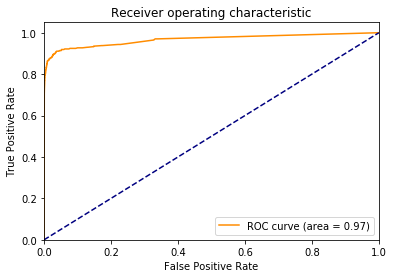

In [90]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [83]:
probs_df = pd.DataFrame(probs)

In [84]:
probs_df

,0,1
0,1.000000,0.000000
1,0.992000,0.008000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,0.999000,0.001000
6,0.996000,0.004000
7,0.999000,0.001000
8,1.000000,0.000000
9,1.000000,0.000000
